## Previously defined functions

In [1]:
# functions used regularly in examples

import numpy as np
np.random.seed(12345)

def laplace(shift=0., scale=1., size=None):
    """Sample from the laplace distribution."""
    p = np.random.uniform(low=-0.5, high=0.5, size=size)
    draws = shift - scale * np.sign(p) * np.log(1 - 2 * abs(p))
    return draws

    # the easy way
    # return np.random.laplace(loc=shift, scale=scale, size=size)


def gaussian(shift=0., scale=1., size=None):
    """Sample from the Gaussian distribution."""
    draws = np.random.normal(loc=shift, scale=scale, size=size)
    return draws


def clamp(x, bounds):
    """Replace any x_i less than lower with lower,
           and any x_i greater than upper with upper."""
    return np.clip(x, *bounds)


def bounded_mean(x, bounds):
    x_clamped = clamp(x, bounds)
    return np.mean(x_clamped)


def release_dp_mean(x, bounds, epsilon, delta=1e-6, mechanism="laplace"):
    """Release a DP mean.
    Assumes that the dataset size n is public information.
    """
    sensitive_mean = bounded_mean(x, bounds)

    n = len(x)
    lower, upper = bounds
    # Sensitivity in terms of an absolute distance metric
    # Both the laplace and gaussian mechanisms can noise queries
    #    with sensitivities expressed in absolute distances
    sensitivity = (upper - lower) / n

    if mechanism == "laplace":
        scale = sensitivity / epsilon
        dp_mean = sensitive_mean + laplace(scale=scale)
    elif mechanism == "gaussian":
        scale = (sensitivity / epsilon) * np.sqrt(2*np.log(2/delta))
        dp_mean = sensitive_mean + gaussian(scale=scale)
    else:
        raise ValueError(f"unrecognized mechanism: {mechanism}")

    return dp_mean


def bootstrap(x, n):
    """Sample n values with replacement from n."""
    index = np.random.randint(low=0., high=len(x), size=n)
    return x[index]


def release_dp_histogram(x, epsilon, categories):
    """Release an `epsilon`-DP estimate of the counts of each of the `categories`"""
    sensitivity = 2
    scale = sensitivity / epsilon

    # create a {category: count} hashmap
    counts = dict(zip(*np.unique(x, return_counts=True)))
    # look up the count of each category, or zero if not exists
    sensitive_histogram = np.array([counts.get(cat, 0) for cat in categories])

    dp_histogram = sensitive_histogram + laplace(scale=scale, size=sensitive_histogram.shape)
    return dp_histogram

In [2]:
np.random.seed(12345)

def sigmoid(x):
	return 1 / (1 + np.exp(-x))

## Here is the likelihood function for a Logit
def logit_neg_log_likelihood(beta, data):
	"""negative log likelihood function for a logit
	:param beta: 1darray of [intercept, slope]
	"""
	x, y = data.T

	# Here is the systematic component
	probability = sigmoid(beta[0] + beta[1] * x)

	# Here is the stochastic component
	log_likelihood = y * np.log(probability) + (1 - y) * np.log(1 - probability)

	return -log_likelihood

## Run with actual data

In [3]:
import pandas as pd
data = pd.read_csv(
    "https://raw.githubusercontent.com/privacytoolsproject/cs208/master/data/MaPUMS5full.csv")

# define public information
n = len(data)            # in this case, dataset length is considered public, and is not protected
educ_bounds = (1., 16.)  # easily guessable without looking at the data
data = data[['educ', 'married']].values.astype(float)


In [4]:
from sklearn.linear_model import LogisticRegression

educ = data[:, 0]
married = data[:, 1]
model = LogisticRegression().fit(X = educ[:, None], y=married)
beta = np.array([model.intercept_[0],model.coef_[0, 0]])

print(beta)


[-0.62007089  0.07829374]


## Stochastic Gradient Descent

Based on the paper [Deep Learning with Differential Privacy](https://arxiv.org/pdf/1607.00133.pdf).

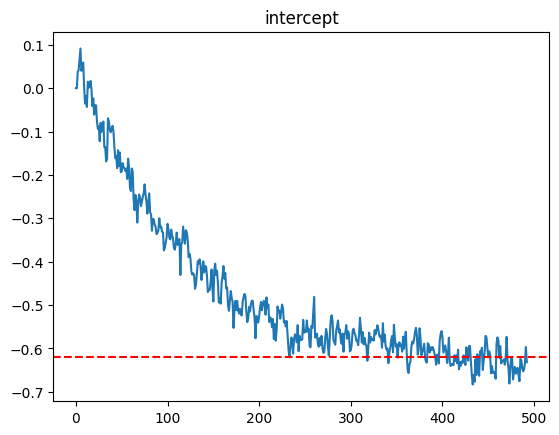

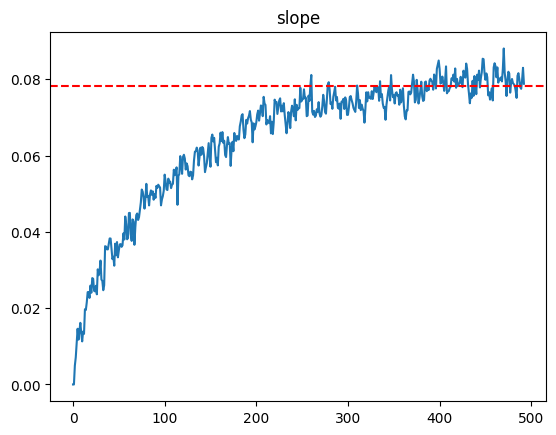

In [5]:
# Calculate the gradient at a point in the parameter space
def calc_clamped_gradient(X, C, theta, fun):
	"""
	:param X: data
	:param C: clipping norm bound
	:param theta: learned param
	:param fun: loss function to optimize"""

	dx = 0.0001
	bounds = [-C, C]

	out1 = fun(beta=theta, data=X)
	out2 = fun(beta=theta + [0, dx], data=X)
	out3 = fun(beta=theta + [dx, 0], data=X)

	Del_1 = (out3-out1) / dx
	Del_1_clamped = clamp(Del_1, bounds=bounds)
	mean_Del_1 = Del_1_clamped.mean()

	Del_2 = (out2-out1) / dx
	Del_2_clamped = clamp(Del_2, bounds=bounds)
	mean_Del_2 = Del_2_clamped.mean()

	# norm = sqrt(Del_1**2 + Del_2**2)
	# Del_1 /= np.maximum(1, norm)
	# Del_2 /= np.maximum(1, norm)

	return np.array([mean_Del_1, mean_Del_2])



N = len(educ)
L = round(np.sqrt(N))     # This is the recommended batch size

steps = np.ceil(N / L)   # Happens to be ~L

## Shuffle the data
np.random.shuffle(data)

# per element per step
epsilon = 1
delta = 1e-6

theta = [0,0]   # Starting parameters
C = 10			# Interval to clip over
nu = [1, 0.01]  # Learning speeds


history = [theta]

# Run one epoch of SGD
for batch in np.array_split(data, steps):
	sensitive_grad = calc_clamped_gradient(X=batch, C=C, theta=theta, fun=logit_neg_log_likelihood)

	sensitivity = 2 * C / L  # 2 * C / len(batch)
	functional_epsilon = epsilon * L/2 # epsilon * sqrt(steps)
	scale = (sensitivity / functional_epsilon) * np.sqrt(2*np.log(2/delta))

	Del = sensitive_grad + gaussian(shift=0, scale=scale, size=2)
	#cat("Del:  ",Del,"\n")
	theta = theta - Del * nu
	#cat("Theta:",theta, "\n")

	history.append(theta)

history = np.array(history)

import matplotlib.pyplot as plt

plt.plot(np.arange(len(history)), history[:, 0])
plt.title("intercept")
plt.axhline(y=model.intercept_[0], color="red", linestyle="--")
plt.show()

plt.plot(np.arange(len(history)), history[:, 1])
plt.title("slope")
plt.axhline(y=model.coef_[0, 0], color="red", linestyle="--")
plt.show()
